In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from tqdm import tqdm_notebook as tqdm
import os
import sys

## Custom Imports

In [2]:
os.chdir("../fashion_ml")

In [3]:
from fashion_vae import FashionVAE
from data_loader import EZ_Dataloader

## Build Data Loader

In [4]:
dl = EZ_Dataloader("FashionMNIST")

In [5]:
dl.build_train_test_loader()

## Build VAE

In [6]:
t = dl.train_loader.dataset

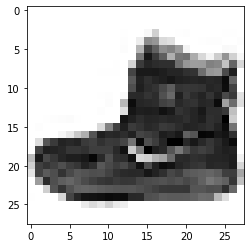

In [7]:
import matplotlib.pyplot as plt
a = t[0][0]
plt.imshow(torch.squeeze(a), cmap = "Greys")

In [8]:
fvae = FashionVAE(h_dims = [32,64,128])

In [9]:
fvae

FashionVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=128, out_features=2, bias=True)
  (fc_var): Linear(in_features=128, out_features=2, bias=True)
  (decoder_latent_space): Linear(in_features=2, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Sequential(

In [10]:
fvae.cuda()
fvae.eval()

FashionVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=128, out_features=2, bias=True)
  (fc_var): Linear(in_features=128, out_features=2, bias=True)
  (decoder_latent_space): Linear(in_features=2, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Sequential(

In [11]:
r = fvae.forward(torch.unsqueeze(a.cuda(),0))

torch.Size([1, 2])
torch.Size([1, 32, 9, 9])
torch.Size([1, 1, 28, 28])
